In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from object_detection import *
from utils import visualization_utils as vis_util
import PIL.Image as Image
# i prefer PIL to draw the text, more beautiful
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
cap = cv2.VideoCapture('test_video.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count, fps

(38, 25.0)

In [3]:
results = []
for i in range(3):
    results.append(np.expand_dims(cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB),0))
results = np.concatenate(results,0)

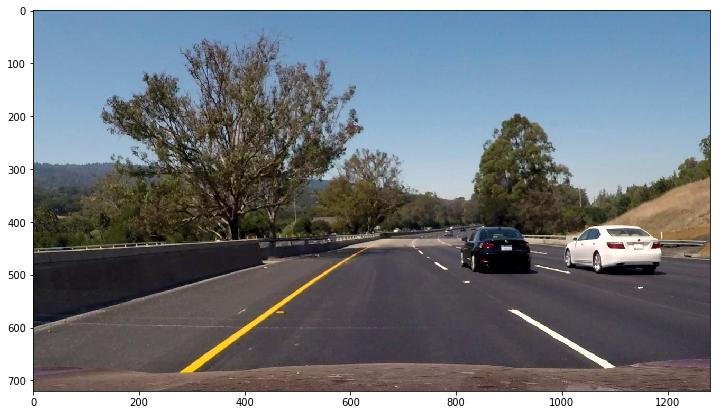

In [4]:
plt.figure(figsize = (15, 7))
plt.imshow(results[0])
plt.show()

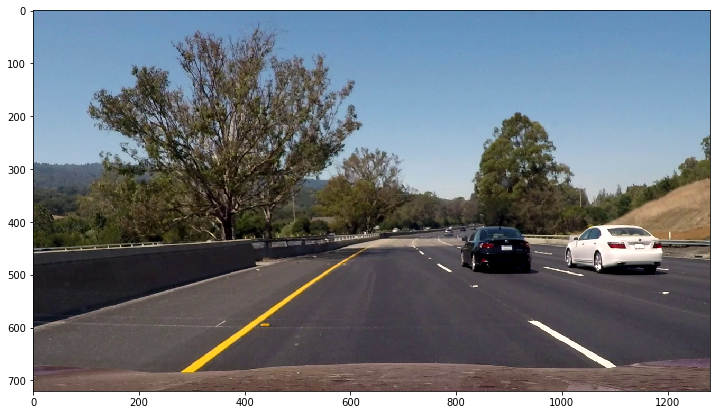

In [5]:
plt.figure(figsize = (15, 7))
plt.imshow(results[1])
plt.show()

In [6]:
initial_width = 2
known_distance = 1
image = results[0]
initial_pixel_distance = (image.shape[1]*0.90 - image.shape[1]*0.1)
focal_length = (initial_pixel_distance * known_distance) / initial_width

# [ymin, xmin, ymax, xmax]
def get_bounding_box(bbox):
    return int(bbox[0]*image.shape[0]),int(bbox[1]*image.shape[1]),\
    int(bbox[2]*image.shape[0]),int(bbox[3]*image.shape[1])

def distance_to_camera(known_width, focal_length, width):
    return (known_width * focal_length) / width

7.641791044776119


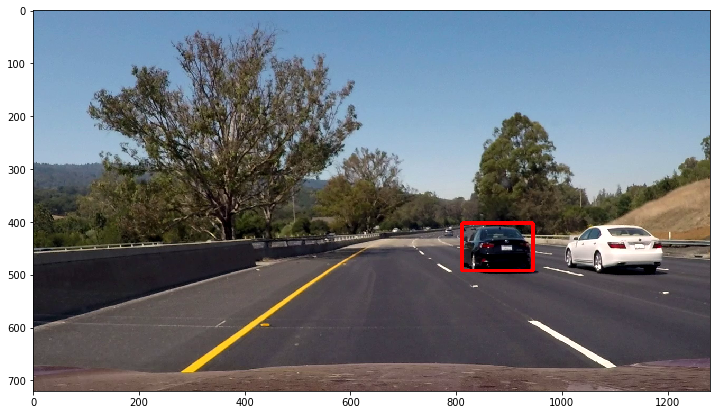

In [7]:
boxes, scores, classes, num_detections = detect_object(results[1])
car_boxes = get_bounding_box(boxes[0,0,:])
distance_car_first_frame = distance_to_camera(initial_width, focal_length, car_boxes[3]-car_boxes[1])
print(distance_car_first_frame)

plt.figure(figsize = (15, 7))
copied = np.copy(results[1])
ymin, xmin, ymax, xmax = get_bounding_box(boxes[0,0,:])
cv2.rectangle(copied,(xmin,ymin),(xmax,ymax),(255,0,0),5)

plt.imshow(copied)
plt.show()

8.0


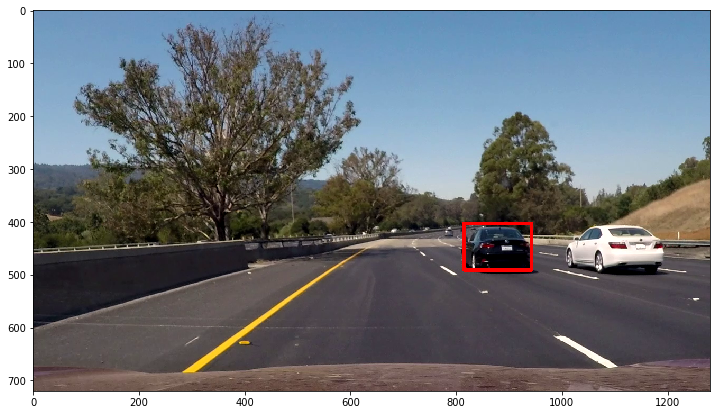

In [8]:
boxes, scores, classes, num_detections = detect_object(results[2])
car_boxes = get_bounding_box(boxes[0,0,:])
distance_car_second_frame = distance_to_camera(initial_width, focal_length, car_boxes[3]-car_boxes[1])
print(distance_car_second_frame)

plt.figure(figsize = (15, 7))
copied = np.copy(results[2])
ymin, xmin, ymax, xmax = get_bounding_box(boxes[0,0,:])
cv2.rectangle(copied,(xmin,ymin),(xmax,ymax),(255,0,0),5)

plt.imshow(copied)
plt.show()

In [9]:
second_between_frames = 1 / fps
speed_car = (distance_car_second_frame-distance_car_first_frame) / second_between_frames
speed_car *= 3.6
our_speed_car = 60
print('that black car speed is %f km/h'%(our_speed_car + speed_car))

that black car speed is 92.238806 km/h


In [10]:
from moviepy.editor import VideoFileClip

In [11]:
def center_box(bbox):
    ymin, xmin, ymax, xmax = get_bounding_box(bbox)
    return int(ymin+((ymax-ymin)/2)), int(xmin+((xmax-xmin)/2))

In [18]:
last_distance = 0
last_boxes = 0
smoothing = 0.8

In [19]:
def process_image(image):
    global last_distance, last_boxes
    speed = 0
    boxes, scores, classes, num_detections = detect_object(image)
    car_boxes = get_bounding_box(boxes[0,0,:])
    distance_boxes = car_boxes[3]-car_boxes[1]
    if not last_boxes:
        last_boxes = distance_boxes
    else:
        distance_boxes = last_boxes * smoothing + (1 - smoothing) * distance_boxes
    distance_car = distance_to_camera(initial_width, focal_length, distance_boxes)
    if not last_distance:
        last_distance = distance_car
    else:
        speed = ((distance_car-last_distance) / second_between_frames) * 3.6
        speed += our_speed_car
        if speed > 200:
            return image
        last_distance = distance_car
    
    copied = np.copy(image)
    ymin, xmin, ymax, xmax = get_bounding_box(boxes[0,0,:])
    car_x, car_y = center_box(boxes[0,0,:])
    cv2.rectangle(copied,(xmin,ymin),(xmax,ymax),(255,0,0),5)

    pil_image = Image.fromarray(np.uint8(copied))
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('Roboto-Regular.ttf', 40)

    draw.text((car_y-100,car_x-100),'distance: %.2fm'%(distance_car),fill='white',font=font)
    draw.text((car_y-100,car_x-150),'speed: %.2fkm/h'%(speed),fill='white',font=font)
    
    return np.array(pil_image)

In [20]:
output_video = 'test_video_output.mp4'
clip1 = VideoFileClip('test_video.mp4')

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output_video, audio = False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:01<00:00, 28.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 3.71 s, sys: 644 ms, total: 4.36 s
Wall time: 2.41 s
